<a href="https://colab.research.google.com/github/Alba251/face_detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Alba251/face_detection.git
%cd face_detection


Cloning into 'face_detection'...
remote: Enumerating objects: 5025, done.
remote: Counting objects: 100% (5025/5025), done.
remote: Compressing objects: 100% (5023/5023), done.
remote: Total 5025 (delta 10), reused 5003 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5025/5025), 32.86 MiB | 18.26 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (5003/5003), done.
/content/face_detection


In [17]:
#LIBRERIAS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tqdm import tqdm


In [18]:
data = pd.read_csv("./data/data.csv", sep=';', dtype={'gender': str})
data.head()

,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,male,70,111,107,111,37
1,1.jpg,male,71,110,106,111,31
2,2.jpg,male,71,111,106,110,37
3,3.jpg,male,68,111,108,112,51
4,4.jpg,male,71,111,106,110,36


In [4]:
print(data.describe(include = "all"))

         im_name  gender  left_eye_x  left_eye_y  right_eye_x  right_eye_y  \
count       5000    5000  5000.00000  5000.00000   5000.00000  5000.000000   
unique      5000       2         NaN         NaN          NaN          NaN   
top     4999.jpg  female         NaN         NaN          NaN          NaN   
freq           1    2884         NaN         NaN          NaN          NaN   
mean         NaN     NaN    69.39320   111.18780    107.60540   111.144200   
std          NaN     NaN     1.73931     1.12338      1.70689     1.179866   
min          NaN     NaN    60.00000   104.00000     93.00000   100.000000   
25%          NaN     NaN    68.00000   111.00000    107.00000   111.000000   
50%          NaN     NaN    69.00000   111.00000    108.00000   111.000000   
75%          NaN     NaN    70.00000   112.00000    109.00000   112.000000   
max          NaN     NaN    86.00000   117.00000    114.00000   122.000000   

                age  
count   5000.000000  
unique          NaN

In [19]:
#Conertimos la columan de male, female a binario

data['gender'] = data['gender'].map({'male':1, 'female':0})
data.head()


,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,1,70,111,107,111,37
1,1.jpg,1,71,110,106,111,31
2,2.jpg,1,71,111,106,110,37
3,3.jpg,1,68,111,108,112,51
4,4.jpg,1,71,111,106,110,36


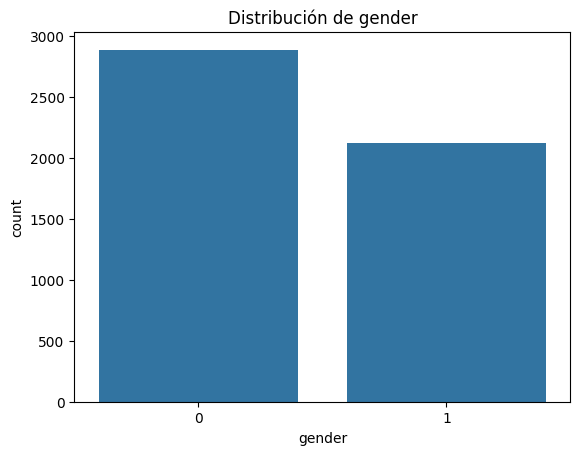

In [ ]:
 #Ahora analizaremos cada variable
sns.countplot(x='gender', data=data)
plt.title("Distribución de gender")
plt.show()

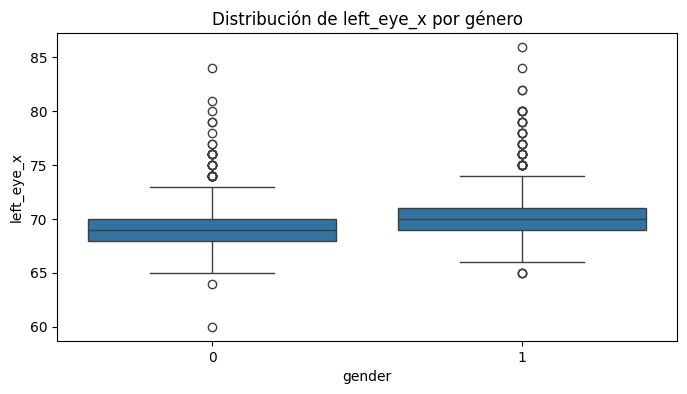

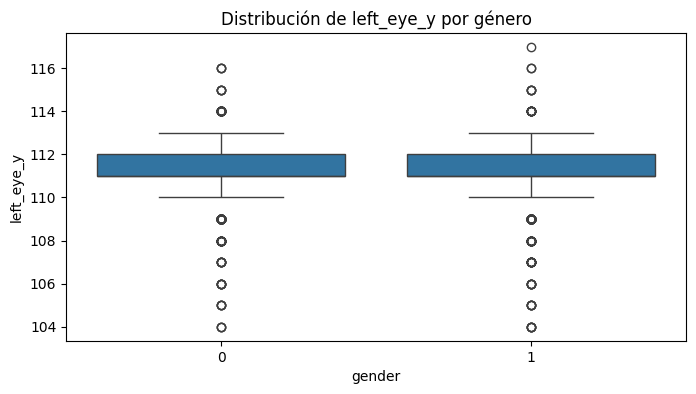

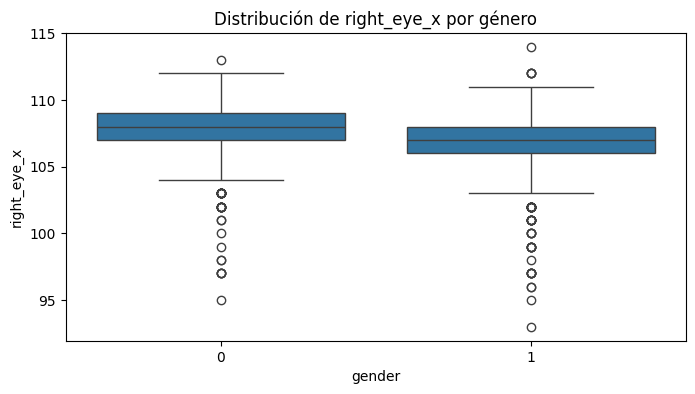

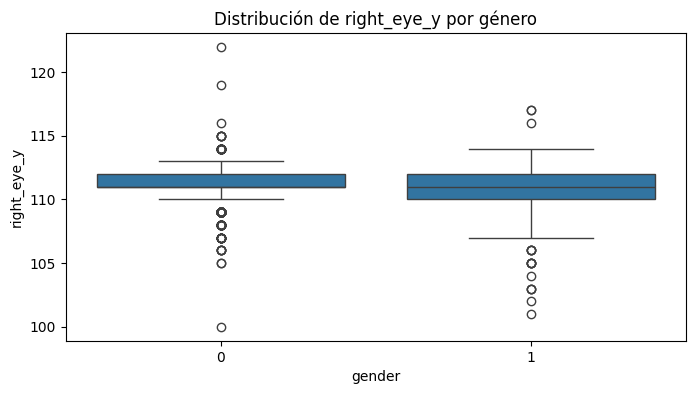

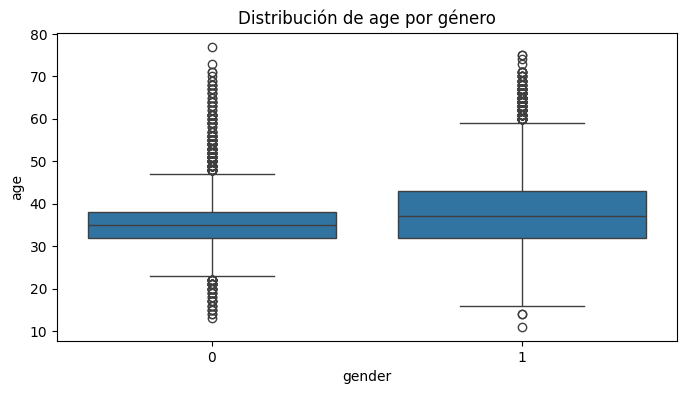

In [ ]:
numerical_cols = ['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y', 'age']

for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='gender', y=col, data=data)
    plt.title(f'Distribución de {col} por género')
    plt.show()

#Tenemos resultados muy diferentes, lo que tiene sentido pq la persona puede estar desplazada...

In [20]:
#Vamos a normalizar los datos de la posicon de los ojos para poder redimensionalizar las imagenes a 224x224

data['left_eye_x'] = data['left_eye_x'] / 178.0
data['right_eye_x'] = data['right_eye_x'] / 178.0
data['left_eye_y'] = data['left_eye_y'] / 218.0
data['right_eye_y'] = data['right_eye_y'] / 218.0
data['age'] = data['age'] / 100.0  # suponiendo que la mayoría no pasa de 100 años, consideramos este valor como máximo posible de edad, dado que un valor mayor generaria un data[age] y la sigmoide no puede dar una posible edad mayor de 1, que son 100


data.head()

,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,1,0.393258,0.509174,0.601124,0.509174,0.37
1,1.jpg,1,0.398876,0.504587,0.595506,0.509174,0.31
2,2.jpg,1,0.398876,0.509174,0.595506,0.504587,0.37
3,3.jpg,1,0.382022,0.509174,0.606742,0.513761,0.51
4,4.jpg,1,0.398876,0.509174,0.595506,0.504587,0.36


In [23]:
#ampliamso el dataset rotando en 90º, 180º, 270º, pasando de 5000 a 20000 imagenes

# Función para cargar y procesar la imagen
def load_and_preprocess_image(filename):
    img_path = os.path.join("data/images/", filename)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # normaliza [0,1]
    image = tf.image.resize(image, [224, 224])  # Resize con el tamaño al que ha sido entrenado ImageNet
    return image

# Ajustar los ojos tras el flip
def flip_horizontal_and_adjust(image, eyes):
    lx, ly, rx, ry = eyes
    flipped_image = tf.image.flip_left_right(image)
    lx_, rx_ = 1 - rx, 1 - lx
    return flipped_image.numpy(), [lx_, ly, rx_, ry]

# Crear carpetas si no existen
os.makedirs('data_augmentation/images', exist_ok=True)

# Dataset aumentado
labels_list = []
saturation_levels = [0.7, 1.0, 1.3]

for idx, row in tqdm(data.iterrows(), total=len(data)):
    try:
        image = load_and_preprocess_image(row['im_name'])
        gender = row['gender']
        age = row['age']
        eyes = [row['left_eye_x'], row['left_eye_y'], row['right_eye_x'], row['right_eye_y']]

        for flip in [False, True]:
            img_proc = tf.identity(image)
            eyes_proc = list(eyes)

            if flip:
                img_proc, eyes_proc = flip_horizontal_and_adjust(img_proc, eyes_proc)

            for s in saturation_levels:
                img_aug = tf.image.adjust_saturation(img_proc, s)
                label = [gender, age] + eyes_proc

                name = row['im_name'].split('.')[0]
                flip_tag = "_flip" if flip else ""
                img_name = f"{name}{flip_tag}_sat{s:.1f}.jpg"
                tf.keras.utils.save_img(f"data_augmentation/images/{img_name}", img_aug.numpy())
                labels_list.append([img_name] + label)
    except Exception as e:
        print(f"Error con {row['im_name']}: {e}")


100%|██████████| 5000/5000 [01:11<00:00, 69.46it/s]


In [8]:
# Crear un DataFrame con las etiquetas
columns = ['im_name', 'gender', 'age', 'left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y']
data_augmentation = pd.DataFrame(labels_list, columns=columns)

# Guardar el DataFrame como archivo CSV
data_augmentation.to_csv('data_augmentation/data_augmentation.csv', index=False)
data_augmentation.head()

,im_name,gender,age,left_eye_x,left_eye_y,right_eye_x,right_eye_y
0,0_rot0.jpg,1,0.37,0.393258,0.509174,0.601124,0.509174
1,0_rot90.jpg,1,0.37,0.509174,0.606742,0.509174,0.398876
2,0_rot180.jpg,1,0.37,0.606742,0.490826,0.398876,0.490826
3,0_rot270.jpg,1,0.37,0.490826,0.393258,0.490826,0.601124
4,1_rot0.jpg,1,0.31,0.398876,0.504587,0.595506,0.509174


In [9]:
#DIVIDIMOS EL DATASET EN TRAIN, TEST, VALIDATE

# Paso 1: dividir primero en train + temp (val+test)
images_train, images_temp, genders_train, genders_temp, ages_train, ages_temp, eyes_train, eyes_temp = train_test_split(
    data['im_name'],
    data['gender'],
    data['age'],
    data[['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y']],
    test_size=0.3,
    stratify=data_augmentation['gender'],
    random_state=42
)

# Paso 2: dividir temp en val y test (mitad y mitad)
images_val, images_test, genders_val, genders_test, ages_val, ages_test, eyes_val, eyes_test = train_test_split(
    images_temp,
    genders_temp,
    ages_temp,
    eyes_temp,
    test_size=0.5,
    stratify=genders_temp,
    random_state=42
)


In [ ]:
#Data augmetnation con train dataset
# Unimos el conjunto de entrenamiento en un DataFrame
train_data = pd.DataFrame({
    'im_name': images_train,
    'gender': genders_train,
    'age': ages_train,
    'left_eye_x': eyes_train['left_eye_x'].values,
    'left_eye_y': eyes_train['left_eye_y'].values,
    'right_eye_x': eyes_train['right_eye_x'].values,
    'right_eye_y': eyes_train['right_eye_y'].values
})

# Crear carpeta si no existe
os.makedirs('data_augmentation/images', exist_ok=True)

# Dataset aumentado (solo para training)
labels_list = []
saturation_levels = [0.7, 1.0, 1.3]

for idx, row in tqdm(train_data.iterrows(), total=len(train_data)):
    try:
        image = load_and_preprocess_image(row['im_name'])
        gender = row['gender']
        age = row['age']
        eyes = [row['left_eye_x'], row['left_eye_y'], row['right_eye_x'], row['right_eye_y']]

        for flip in [False, True]:
            img_proc = tf.identity(image)
            eyes_proc = list(eyes)

            if flip:
                img_proc, eyes_proc = flip_horizontal_and_adjust(img_proc, eyes_proc)

            for s in saturation_levels:
                img_aug = tf.image.adjust_saturation(img_proc, s)
                label = [gender, age] + eyes_proc

                name = row['im_name'].split('.')[0]
                flip_tag = "_flip" if flip else ""
                img_name = f"{name}{flip_tag}_sat{s:.1f}.jpg"
                tf.keras.utils.save_img(f"data_augmentation/images/{img_name}", img_aug.numpy())
                labels_list.append([img_name] + label)
    except Exception as e:
        print(f"Error con {row['im_name']}: {e}")


In [15]:
### Relacionar datos con imagenes para preparar el input del modelo

def load_and_preprocess_image_train(filename):
    img_path = os.path.join("data_augmentation/images/", filename)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

def load_and_preprocess_image_test_val(filename):
    img_path = os.path.join("data/images/", filename)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image


# Dataset de TensorFlow que yield (imagen, etiquetas)
def tf_data_generator(images, genders, ages, eyes, is_train=True):
    for i in range(len(images)):
        if is_train:
            img = load_and_preprocess_image_train(images.iloc[i])
        else:
            img = load_and_preprocess_image_test_val(images.iloc[i])
        gender = genders.iloc[i]
        age = ages.iloc[i]
        eye_pos = eyes.iloc[i].values
        labels = {
            'gender': gender,
            'age': age,
            'eye_pos': eye_pos
        }
        yield img, labels


def create_tf_dataset(images, genders, ages, eyes, is_train=True):
    return tf.data.Dataset.from_generator(
        lambda: tf_data_generator(images, genders, ages, eyes, is_train),
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            {
                'gender': tf.TensorSpec(shape=(), dtype=tf.float32),
                'age': tf.TensorSpec(shape=(), dtype=tf.float32),
                'eye_pos': tf.TensorSpec(shape=(4,), dtype=tf.float32),
            }
        )
    )

train_dataset = create_tf_dataset(images_train, genders_train, ages_train, eyes_train, is_train=True)
val_dataset = create_tf_dataset(images_val, genders_val, ages_val, eyes_val, is_train=False)
test_dataset = create_tf_dataset(images_test, genders_test, ages_test, eyes_test, is_train=False)

#AÑADE BATCH Y PREFETCH PARA MEJORAR EL RENDIMIENTO

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



# Forzar una pequeña iteración para probar el generador
for img, label in train_dataset.take(5):
    pass  # solo itera, el print ya está en load_and_preprocess_image




{'gender': <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.],
      dtype=float32)>, 'age': <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.28, 0.27, 0.36, 0.38, 0.32, 0.3 , 0.37, 0.36, 0.32, 0.39, 0.32,
       0.35, 0.47, 0.41, 0.3 , 0.39, 0.39, 0.4 , 0.37, 0.51, 0.48, 0.41,
       0.36, 0.31, 0.37, 0.65, 0.21, 0.35, 0.35, 0.53, 0.36, 0.53],
      dtype=float32)>, 'eye_pos': <tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[0.49082568, 0.38764045, 0.48623854, 0.6011236 ],
       [0.48623854, 0.38202247, 0.49082568, 0.6123595 ],
       [0.5091743 , 0.6179775 , 0.51376146, 0.39325842],
       [0.6179775 , 0.49082568, 0.38764045, 0.48623854],
       [0.6123595 , 0.48165137, 0.38764045, 0.49082568],
       [0.6235955 , 0.48165137, 0.38202247, 0.48623854],
       [0.38764045, 0.5045872 , 0.6011236 , 0.51376146],
       [0.48623854, 0.3764

In [11]:
# Input layer
input_img = Input(shape=(224, 224, 3))

# Backbone CNN preentrenada
base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binaria)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)

# Output 2: Age (regresión)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regresión 4 valores)
eye_output = Dense(4, name='eye_pos')(x)

# Modelo final
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)


<ipython-input-11-d419e6434ce9>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
#ENTRENAMOS EL MODELO

####SEMILLLAAAAA


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(images_train) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)



Epoch 1/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 105s 127ms/step - age_loss: 0.1209 - age_mae: 0.1864 - eye_pos_loss: 0.0603 - eye_pos_mae: 0.1420 - gender_accuracy: 0.8824 - gender_loss: 0.2689 - loss: 0.4501 - val_age_loss: 6.7404 - val_age_mae: 2.4960 - val_eye_pos_loss: 11.5476 - val_eye_pos_mae: 3.1868 - val_gender_accuracy: 0.7970 - val_gender_loss: 1.6394 - val_loss: 19.9274
Epoch 2/20
  1/437 ━━━━━━━━━━━━━━━━━━━━ 2:21:43 20s/step - age_loss: 0.0062 - age_mae: 0.0610 - eye_pos_loss: 0.0044 - eye_pos_mae: 0.0502 - gender_accuracy: 0.9375 - gender_loss: 0.1531 - loss: 0.1637

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


437/437 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - age_loss: 0.0062 - age_mae: 0.0610 - eye_pos_loss: 0.0044 - eye_pos_mae: 0.0502 - gender_accuracy: 0.9375 - gender_loss: 0.1531 - loss: 0.1637 - val_age_loss: 6.5785 - val_age_mae: 2.4643 - val_eye_pos_loss: 11.3819 - val_eye_pos_mae: 3.1612 - val_gender_accuracy: 0.8031 - val_gender_loss: 1.5668 - val_loss: 19.5271
Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - age_loss: 0.0077 - age_mae: 0.0667 - eye_pos_loss: 0.0037 - eye_pos_mae: 0.0475 - gender_accuracy: 0.9537 - gender_loss: 0.1142 - loss: 0.1256 - val_age_loss: 0.6519 - val_age_mae: 0.7496 - val_eye_pos_loss: 4.1992 - val_eye_pos_mae: 1.9769 - val_gender_accuracy: 0.6694 - val_gender_loss: 2.7037 - val_loss: 7.5548
Epoch 4/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - age_loss: 0.0081 - age_mae: 0.0620 - eye_pos_loss: 0.0034 - eye_pos_mae: 0.0496 - gender_accuracy: 1.0000 - gender_loss: 0.0148 - loss: 0.0264 - val_age_loss: 0.8114 - val_age_mae: 0.8518 - val_eye_pos_loss: 4

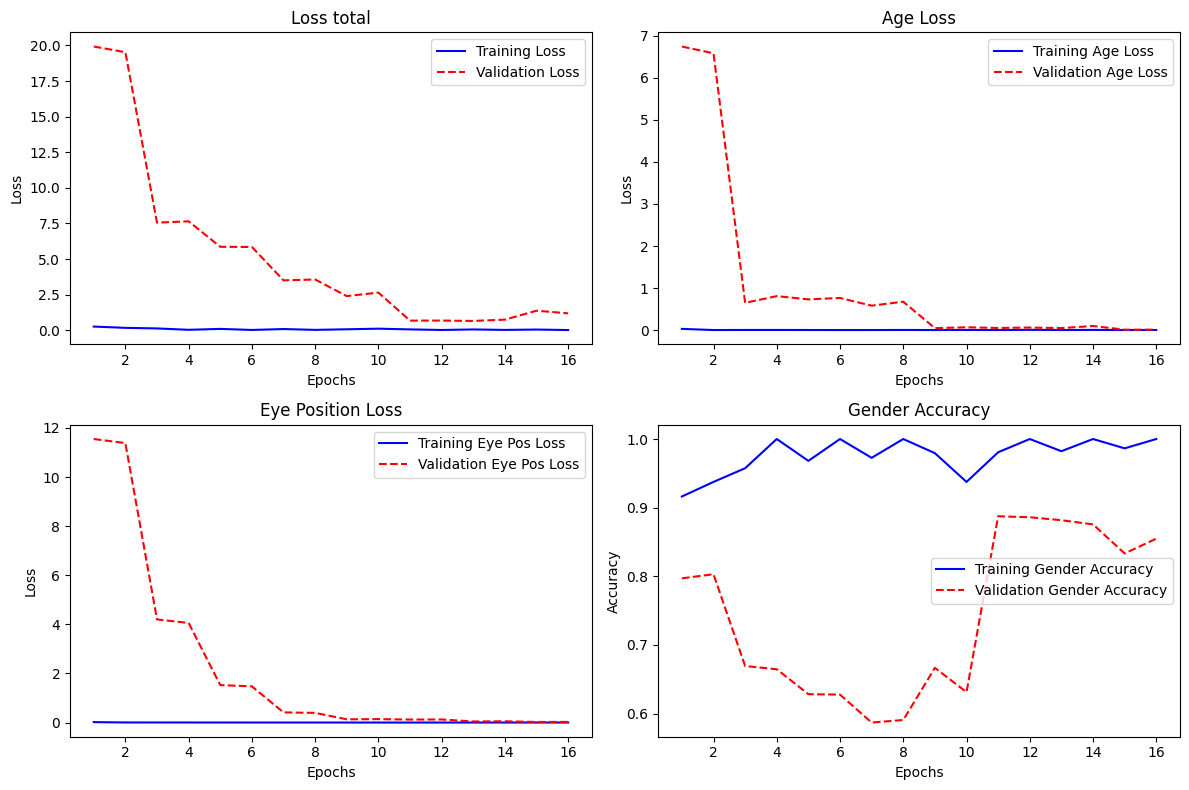

In [13]:
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot loss total vs val_loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
    plt.title('Loss total')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot age_loss vs val_age_loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['age_loss'], 'b-', label='Training Age Loss')
    plt.plot(epochs, history.history['val_age_loss'], 'r--', label='Validation Age Loss')
    plt.title('Age Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot eye_pos_loss vs val_eye_pos_loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.history['eye_pos_loss'], 'b-', label='Training Eye Pos Loss')
    plt.plot(epochs, history.history['val_eye_pos_loss'], 'r--', label='Validation Eye Pos Loss')
    plt.title('Eye Position Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot gender_accuracy vs val_gender_accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.history['gender_accuracy'], 'b-', label='Training Gender Accuracy')
    plt.plot(epochs, history.history['val_gender_accuracy'], 'r--', label='Validation Gender Accuracy')
    plt.title('Gender Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Llamar a la función con tu objeto history
plot_training_history(history)


In [ ]:
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), {'gender': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'age': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'eye_pos': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)})>


In [14]:
test_results = model.evaluate(test_dataset, verbose=1)
print("Test loss and metrics:", test_results)

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - age_loss: 0.0544 - age_mae: 0.1948 - eye_pos_loss: 0.0449 - eye_pos_mae: 0.1706 - gender_accuracy: 0.8859 - gender_loss: 0.5761 - loss: 0.6754
Test loss and metrics: [0.6691594123840332, 0.5730417966842651, 0.05372771993279457, 0.044383227825164795, 0.1936100870370865, 0.1698416918516159, 0.8843333125114441]
